## Blend Backdoor attack on DP-SGD training 
- CIFAR 10 dataset
- Clean label attack

Blend attack : https://openaccess.thecvf.com/content/ICCV2021/papers/Li_Invisible_Backdoor_Attack_With_Sample-Specific_Triggers_ICCV_2021_paper.pdf

In [40]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import opacus
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

from opacus.utils.uniform_sampler import UniformWithReplacementSampler

In [41]:
#set device
torch.cuda.set_device(4)
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = 'cuda'

In [42]:
# #define model
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x, last=False):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output = self.fc3(x)
        
        if last:
            return output, x
        else:
            return output

#     def getFeature(self, x, numpy=True):
#         if x.shape[1]==32:
#           x = np.moveaxis(x, 3, 1)
#         x = torch.Tensor(x).cuda()
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1)
#         if numpy:
#           return x.detach().cpu().numpy()
#         else:
#           return x

#     def get_embedding_dim(self):
#         return 84


In [43]:
from torchvision.models import resnet18
model=resnet18()
criterion=nn.CrossEntropyLoss()

# from opacus.utils.module_modification import convert_batchnorm_modules

# model = convert_batchnorm_modules(model)  # Note that we are using the backbone as a black-box featurizer. It's never trained, so we can keep BatchNorms in there.
# model=model.cuda()

# # The optimizer needs to point to the new model

# optimizer=torch.optim.SGD(model.parameters(), lr=0.03 ,
#                       momentum=0.9, weight_decay=5e-4, nesterov=True)

In [44]:
# model=SmallCNN().cuda()
# criterion=nn.CrossEntropyLoss()
# optimizer=torch.optim.SGD(model.parameters(),lr=0.07, momentum=False
                              
#                              )


In [148]:
privacy_engine=opacus.PrivacyEngine(model,
                                   batch_size=64,
                                   sample_size=50000,
                                   alphas=range(2,32),
                                   noise_multiplier=0.01,
                                   
                                   max_grad_norm=8.0)
privacy_engine.attach(optimizer)


In [127]:
def train(model, train_loader, valloader, optimizer, epoch, device, delta,testset_size=10000):
    
    for e in range(epoch):
        
        model.train()
        criterion = torch.nn.CrossEntropyLoss()
        losses = []
        
        for _batch_idx, (data, target) in enumerate(tqdm(train_loader)):
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        epsilon, best_alpha = optimizer.privacy_engine.get_privacy_spent(delta)

        print(
            f"Train Epoch: {e} \t"
            f"Loss: {np.mean(losses):.6f} "
        
            f"(ε = {epsilon:.2f}, δ = {delta}) for α = {best_alpha}"
        )
        running_accuracy=0
        with torch.no_grad(): 
            model.eval() 
            for data,labels in valloader: 
                data, labels = data.cuda(), labels.cuda()

                pred = F.softmax(model(data),dim=1) 
        #                 val_loss = self.criterion(pred, labels) 

                # The label with the highest value will be our prediction 
        #                 _, predicted = torch.max(pred, 1) 
        #                 running_vall_loss += val_loss.item()  
        #                 total += lables.size(0) 
                _,predicted=torch.max(pred,1)

                running_accuracy += (predicted == labels).sum().item()
        running_accuracy/=testset_size
        print(running_accuracy)

In [128]:
total_size = 50000
print('==> Preparing data..')
from torchvision.datasets import CIFAR10
root = '../data/'

trainset = CIFAR10(root, train=True, transform=transforms.Compose([transforms.ToTensor()]), download=True)
# x_train, y_train = trainset.data, trainset.targets
# x_train = x_train.astype('float32')/255
# y_train = np.asarray(y_train)


testset = CIFAR10(root, train=False, transform=transforms.Compose([transforms.ToTensor()]), download=True)
# x_test, y_test = testset.data, testset.targets
# x_test = x_test.astype('float32')/255
# y_test = np.asarray(y_test)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [129]:
train_loader=DataLoader(trainset, batch_size=128, shuffle=True)
test_loader=DataLoader(testset, batch_size=128, shuffle=True)

In [149]:
train(model, train_loader, test_loader, optimizer, 40, device, delta=1e-5)

In [ ]:
train_loader.dataset[0]

## Poisoned data section


In [130]:
#custom poi_util
import random
import imageio
from aug_util import CustomTensorDataset
def patching(clean_sample, attack, pert=None, dataset_nm = 'CIFAR'):
    '''
    this code conducts a patching procedure to generate backdoor data
    **please make sure the input sample's label is different from the target label
    clean_sample: clean input
    '''
    output = np.copy(clean_sample)
    try:
        if attack == 'badnets':
            pat_size = 4
            output[32 - 1 - pat_size:32 - 1, 32 - 1 - pat_size:32 - 1, :] = 1
        else:

            if attack == 'l0_inv':
                trimg = imageio.imread('./triggers/' + attack + '.png') / 255
                mask = 1 - np.transpose(np.load('./triggers/mask.npy'), (1, 2, 0))
                output = clean_sample * mask + trimg
            elif attack == 'smooth':
                if dataset_nm == 'GTSRB':
                    trimg = np.load('triggers/gtsrb_universal.npy')[0]
                elif dataset_nm == 'CIFAR':
                    trimg = np.load('triggers/best_universal.npy')[0]
                output = clean_sample + trimg
                output = normalization(output)
            else:
                trimg = imageio.imread('./triggers/' + attack + '.png') / 255
                output = clean_sample + trimg
        output[output < 0] = 0
        output[output > 1] = 1
        return output
    except:
        if attack == 'badnets':
            pat_size = 4
            output[32 - 1 - pat_size:32 - 1, 32 - 1 - pat_size:32 - 1, :] = 1
        else:

            if attack == 'l0_inv':
                trimg = imageio.imread('./triggers/' + attack + '.png') / 255
                mask = 1 - np.transpose(np.load('./triggers/mask.npy'), (1, 2, 0))
                output = clean_sample * mask + trimg
            elif attack == 'smooth':
                if dataset_nm == 'GTSRB':
                    trimg = np.load('triggers/gtsrb_universal.npy')[0]
                elif dataset_nm == 'CIFAR':
                    trimg = np.load('triggers/best_universal.npy')[0]
                output = clean_sample + trimg
                output = normalization(output)
            else:
                trimg = imageio.imread('./triggers/' + attack + '.png') / 255
                output = clean_sample + trimg
        output[output < 0] = 0
        output[output > 1] = 1
        return output


def poison_dataset(dataset, label, attack, target_lab=6, portion =0.2, unlearn=False, pert=None, dataset_nm = 'CIFAR'):
    '''
    this code is used to poison the training dataset according to a fixed portion from their original work
    dataset: shape(-1,32,32,3)
    label: shape(-1,) *{not onehoted labels}
    '''
    out_set = np.copy(dataset)
    out_lab = np.copy(label)

    # portion = 0.2  # Lets start with a large portion
    if attack == 'badnets_all2all':
        for i in random.sample(range(0, dataset.shape[0]), int(dataset.shape[0] * portion)):
            out_set[i] = patching(dataset[i], 'badnets')
            out_lab[i] = label[i] + 1
            # if out_lab[i] == 10:
            if dataset_nm == 'CIFAR':
                if out_lab[i] == 10:
                    out_lab[i] = 0
            elif dataset_nm == 'GTSRB':
                if out_lab[i] == 43:
                    out_lab[i] = 0
    else:
        indexs = list(np.asarray(np.where(label != target_lab))[0]) #dirty lab
        samples_idx = random.sample(indexs, int(dataset.shape[0] * portion))
        for i in samples_idx:
            out_set[i] = patching(dataset[i], attack, pert, dataset_nm = dataset_nm)
            assert out_lab[i] != target_lab
            out_lab[i] = target_lab
    if unlearn:
        return out_set, label
    return out_set, out_lab, samples_idx


def patching_test(dataset, label, attack, target_lab=6, adversarial=False, dataset_nm='CIFAR'):
    """
    This code is used to generate an all-poisoned dataset for evaluating the ASR
    """
    out_set = np.copy(dataset)
    out_lab = np.copy(label)
    if attack == 'badnets_all2all':
        for i in range(out_set.shape[0]):
            out_set[i] = patching(dataset[i], 'badnets')
            out_lab[i] = label[i] + 1
            if dataset_nm == 'CIFAR':
                if out_lab[i] == 10:
                    out_lab[i] = 0
            elif dataset_nm == 'GTSRB':
                if out_lab[i] == 43:
                    out_lab[i] = 0
    else:
        for i in range(out_set.shape[0]):
            out_set[i] = patching(dataset[i], attack, dataset_nm = dataset_nm)
            out_lab[i] = target_lab
    if adversarial:
        return out_set, label
    return out_set, out_lab



In [131]:
attack_name = 'blend'
target_lab = 0

In [132]:
total_size = 50000
print('==> Preparing data..')
from torchvision.datasets import CIFAR10
root = '../data/'

trainset = CIFAR10(root, train=True, transform=transforms.Compose([transforms.ToTensor()]), download=True)
x_train, y_train = trainset.data, trainset.targets
x_train = x_train.astype('float32')/255
y_train = np.asarray(y_train)


testset = CIFAR10(root, train=False, transform=transforms.Compose([transforms.ToTensor()]), download=True)
x_test, y_test = testset.data, testset.targets
x_test = x_test.astype('float32')/255
y_test = np.asarray(y_test)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [133]:
x_poi_train, y_poi_train, poisoned_idx = poison_dataset(x_train, y_train, attack=attack_name, target_lab=target_lab, portion =0.1, unlearn=False, pert=None, dataset_nm = 'CIFAR')

/home/himanshugj/miniconda3/envs/project1/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


In [134]:
set(poisoned_idx)

{6,
 13,
 32797,
 32,
 36,
 53,
 32832,
 68,
 32838,
 78,
 81,
 82,
 87,
 96,
 97,
 100,
 112,
 32880,
 118,
 127,
 137,
 32909,
 153,
 32925,
 158,
 160,
 164,
 32939,
 171,
 32941,
 174,
 193,
 194,
 32962,
 195,
 221,
 230,
 235,
 33009,
 251,
 254,
 260,
 33043,
 33046,
 313,
 33082,
 33086,
 320,
 33090,
 33093,
 33094,
 33101,
 334,
 33105,
 338,
 33110,
 343,
 346,
 33114,
 33122,
 33123,
 356,
 33125,
 365,
 370,
 33139,
 380,
 388,
 398,
 33167,
 33178,
 416,
 33184,
 423,
 33196,
 33209,
 460,
 33231,
 33247,
 485,
 500,
 33278,
 513,
 33282,
 520,
 530,
 532,
 536,
 537,
 542,
 33316,
 551,
 554,
 558,
 33334,
 33338,
 33348,
 581,
 33351,
 33359,
 602,
 33371,
 609,
 33379,
 33381,
 33382,
 616,
 635,
 638,
 641,
 33411,
 649,
 33429,
 33430,
 668,
 33437,
 674,
 33450,
 33454,
 33457,
 33464,
 697,
 699,
 33477,
 715,
 33484,
 33488,
 742,
 33511,
 750,
 33525,
 33527,
 761,
 766,
 768,
 33536,
 770,
 33541,
 778,
 33548,
 33554,
 787,
 33556,
 33557,
 33560,
 800,
 33578,

In [135]:
no_idx = np.where(y_test!=target_lab)

In [136]:
x_poi_test,y_poi_test= patching_test(x_test[no_idx], y_test[no_idx], attack_name,target_lab=target_lab,dataset_nm='CIFAR')

/home/himanshugj/miniconda3/envs/project1/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


In [137]:
# augmentation
y_poi_train = torch.Tensor(y_poi_train.reshape((-1,)).astype(np.int))
y_test = torch.Tensor(y_test.reshape((-1,)).astype(np.int))
y_poi_test = torch.Tensor(y_poi_test.reshape((-1,)).astype(np.int))




x_poi_train = (x_poi_train)
x_test = (x_test)
x_poi_test = (x_poi_test)

transform1=transforms.Compose([transforms.ToTensor()])

# train_transform, test_transform = get_transforms()

# train_poi_set = CustomTensorDataset(x_poi_train,y_poi_train, transform = train_transform)
# test_set = CustomTensorDataset(x_test,y_test, transform = test_transform)
# poi_val_set = CustomTensorDataset(x_poi_test,y_poi_test, transform = test_transform)

In [138]:

train_poi_set=CustomTensorDataset(x_poi_train,y_poi_train, transform1)
test_set = CustomTensorDataset(x_poi_test, y_poi_test, transform1)


In [139]:
train_poi_set[0]

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
          [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
          [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
          ...,
          [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
          [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
          [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
         [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
          [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
          [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
          ...,
          [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
          [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
          [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
         [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
          [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
          [0.0824, 0.0000, 0.0314,  ...,

### Plot the image to see if trigger is visible 



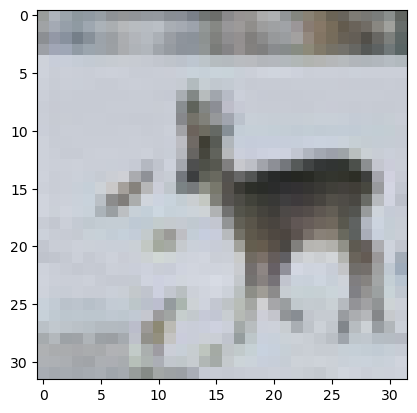

In [140]:
plt.imshow(np.transpose(train_poi_set[20][0],(1,2,0)))

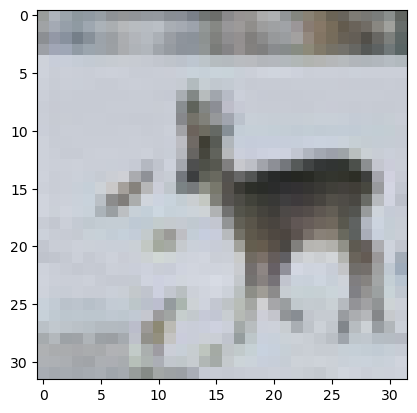

In [143]:
plt.imshow(x_train[20]
          )

In [142]:
train_loader_poi=DataLoader(train_poi_set, batch_size=128, shuffle=True)
test_loader_poi=DataLoader(test_set, batch_size=128, shuffle=True)

In [145]:
from torchvision.models import resnet18
model=resnet18()
criterion=nn.CrossEntropyLoss()

from opacus.utils.module_modification import convert_batchnorm_modules

model = convert_batchnorm_modules(model)  # Note that we are using the backbone as a black-box featurizer. It's never trained, so we can keep BatchNorms in there.
model=model.cuda()

# The optimizer needs to point to the new model

optimizer=torch.optim.SGD(model.parameters(), lr=0.03 ,
                      momentum=0.9, weight_decay=5e-4, nesterov=True)

In [124]:
# model=SmallCNN().cuda()
# criterion=nn.CrossEntropyLoss()
# optimizer=torch.optim.SGD(model.parameters(),lr=0.00009, momentum=True
                              
#                              )




In [146]:
privacy_engine=opacus.PrivacyEngine(model,
                                   batch_size=64,
                                   sample_size=50000,
                                   alphas=range(2,32),
                                   noise_multiplier=0.01,
                                   
                                   max_grad_norm=4.0)
privacy_engine.attach(optimizer)


/home/himanshugj/miniconda3/envs/project1/lib/python3.7/site-packages/opacus/privacy_engine.py:753: UserWarning: The sample rate will be defined from ``batch_size`` and ``sample_size``.The returned privacy budget will be incorrect.
  "The sample rate will be defined from ``batch_size`` and ``sample_size``."
/home/himanshugj/miniconda3/envs/project1/lib/python3.7/site-packages/opacus/privacy_engine.py:237: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "


In [147]:
train(model, train_loader_poi, test_loader_poi, optimizer, 20, device, delta=1e-5)

  0%|          | 0/391 [00:00<?, ?it/s]

/home/himanshugj/miniconda3/envs/project1/lib/python3.7/site-packages/torch/nn/modules/module.py:1113: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Train Epoch: 0 	Loss: 1.778588 (ε = 3904801.31, δ = 1e-05) for α = 2.0
0.8711


  0%|          | 0/391 [00:00<?, ?it/s]

KeyboardInterrupt: 